### Extract Countries sample from PISA 2018
Student questionnaire data downloaded from: https://www.oecd.org/pisa/data/2018database/

In [3]:
import pandas as pd
import pyreadstat
import os
import datetime as dt
from linearmodels.iv import IV2SLS 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
curr_dir = os.getcwd() # get the path to the current folder
fpath = curr_dir+"/pisa2018_student_data.sas7bdat" # add file name to the filepath 

In [ ]:
# Load country background data
country_df = pd.read_csv(curr_dir+"/pisa_country_map.csv")
country_df['cut-off month'] = country_df['cut-off birthdate'].map(lambda x: dt.datetime.strptime(str(x), '%d/%m').month if "/" in str(x) else None)
before = country_df.shape[0]
country_df = country_df.dropna(axis=0)
print(f"Out of {before} countries, {before - country_df.shape[0]} have missing data on school entry cut-off birthdate")
country_map = country_df.set_index('code')['name'].to_dict()
country_cutoff_map = country_df.set_index('code')['cut-off month'].to_dict()

In [4]:
# Load variable code-name map from PISA 2018 codebook

var_df = pd.read_csv(curr_dir+"/pisa_variable_map.csv")
var_map = var_df.set_index('variable code')['variable name'].to_dict()

var_lst = ['PV1READ', 'PV2READ', 'PV3READ', 'PV4READ', 'PV5READ', 'PV6READ', 'PV7READ', 'PV8READ', 'PV9READ', 'PV10READ', 
           'PV1MATH', 'PV2MATH', 'PV3MATH', 'PV4MATH', 'PV5MATH', 'PV6MATH', 'PV7MATH', 'PV8MATH', 'PV9MATH', 'PV10MATH', 
            'PV1SCIE', 'PV2SCIE', 'PV3SCIE', 'PV4SCIE', 'PV5SCIE', 'PV6SCIE', 'PV7SCIE', 'PV8SCIE', 'PV9SCIE', 'PV10SCIE',
           'CNTSTUID','CNTSCHID', 'CNTRYID', 'ST003D02T', 'AGE', 'ST007Q01TA', 'ST005Q01TA', 'HISEI', 'PAREDINT', 'ST004D01T', 
           'ST011Q04TA', 'ST011Q06TA', 'STRATUM', 'DURECEC', 'ESCS', "ST001D01T", "W_FSTUWT"]

column_rename_map = {
    "ST003D02T": "birth_month",
    "ST007Q01TA": "father_schooling", 
    "ST005Q01TA": "mother_schooling",
    "ST004D01T": "gender",
    "ST011Q04TA": "computer_at_home", 
    "ST011Q06TA": "internet_at_home",
    "ST001D01T": "grade",
    "W_FSTUWT": "final_student_weight"
}

In [10]:
# Build a subsample that consists of Latin American countries that took part in PISA 2018s
offset = 0
df, _ = pyreadstat.read_sas7bdat(fpath, row_offset=offset, row_limit=50000)
ret = pd.DataFrame(columns=df.columns)

while not df.empty:
    ret = pd.concat([ret, df])
    offset += 50000
    df, _ = pyreadstat.read_sas7bdat(fpath, row_offset=offset, row_limit=50000)

ret['CNTRYID'] = ret['CNTRYID'].astype(int)
ret['OECD'] = ret['OECD'].astype(int)
ret = ret[ret['CNTRYID'].isin(list(country_map.keys()))]
ret = ret[ret['OECD'] == 1]
ret.to_csv(curr_dir+"/pisa2018_sample2.csv", index=False)

In [ ]:
temp = pd.read_csv(curr_dir+"/pisa2018_sample2.csv")

temp = ret[var_lst].dropna()
temp.rename(columns=column_rename_map, inplace=True)

# Convert age into age in months and compute assigned relative age
temp['age_month'] = np.round(temp['AGE']*12,decimals=0)
temp['cut-off month'] = temp['CNTRYID'].map(lambda x: country_cutoff_map[x])
temp['R'] = (temp['cut-off month'] - temp['birth_month'] + 12) % 12

# Standardise age_in_months
temp['age_month_std'] = (temp['age_month'] - temp['age_month'].min()) / (temp['age_month'].max() - temp['age_month'].min())


cutoff_country_omit = [40, 170, 442, 620] # omit country with no school entry cut-off birth date
temp = temp[~temp["CNTRYID"].isin(cutoff_country_omit)]
temp.to_csv(curr_dir+"/reg_data.csv")

In [4]:
temp = pd.read_csv(os.getcwd()+'/reg_data.csv')
print(temp[['PV1MATH', 'PV1SCIE', 'PV1READ','age_month','birth_month','gender', 'HISEI', 'PAREDINT', 'DURECEC', 'computer_at_home', 'internet_at_home']].describe().T.applymap("{:,.0f}".format).to_latex())

\begin{tabular}{lllllllll}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
PV1MATH & 122,089 & 502 & 91 & 117 & 440 & 505 & 566 & 841 \\
PV1SCIE & 122,089 & 499 & 93 & 72 & 433 & 500 & 564 & 863 \\
PV1READ & 122,089 & 498 & 96 & 121 & 432 & 500 & 566 & 871 \\
age_month & 122,089 & 190 & 3 & 181 & 187 & 190 & 193 & 196 \\
birth_month & 122,089 & 6 & 3 & 1 & 4 & 7 & 9 & 12 \\
gender & 122,089 & 1 & 0 & 1 & 1 & 1 & 2 & 2 \\
HISEI & 122,089 & 52 & 22 & 11 & 30 & 55 & 73 & 89 \\
PAREDINT & 122,089 & 14 & 3 & 3 & 12 & 14 & 16 & 16 \\
DURECEC & 122,089 & 3 & 1 & 0 & 2 & 3 & 3 & 8 \\
computer_at_home & 122,089 & 1 & 0 & 1 & 1 & 1 & 1 & 2 \\
internet_at_home & 122,089 & 1 & 0 & 1 & 1 & 1 & 1 & 2 \\
\bottomrule
\end{tabular}



In [32]:
formula = 'age_month ~ 1 + R + C(gender) + R:C(gender) + HISEI + PAREDINT + computer_at_home + internet_at_home'

first_coeffs = {}

for c in temp['CNTRYID'].unique():
    dfg = temp[temp['CNTRYID'] == c]
    mod = IV2SLS.from_formula(formula, dfg).fit(cov_type='unadjusted')
    first_coeffs[c] = round(mod.params[1],3)

df = pd.DataFrame.from_dict(first_coeffs, orient='index', columns=['First-stage Estimate'])
df['Country Code'] = df.index
df.reset_index(inplace=True)
df['Country'] = df['Country Code'].map(lambda x: country_map[x])
df = df.merge(country_df[["code", "cut-off birthdate"]], how="left", left_on="Country Code", right_on="code")
df = df.sort_values(axis=0, by='First-stage Estimate', ascending=False)
df['First-stage Estimate'] = df['First-stage Estimate'].map(lambda x: round(x, 3))
df.reset_index(inplace=True)
print(df[['Country','cut-off birthdate']].to_latex(index=False))

\begin{tabular}{ll}
\toprule
Country & cut-off birthdate \\
\midrule
Denmark & 31/12 \\
Italy & 31/12 \\
France & 31/12 \\
Mexico & 31/12 \\
Spain & 31/12 \\
Poland & 31/12 \\
Netherlands & 31/12 \\
Iceland & 31/12 \\
United Kingdom & 31/08 \\
Chile & 31/03 \\
Finland & 31/12 \\
Japan & 01/04 \\
Korea & 31/12 \\
Estonia & 01/10 \\
Turkey & 30/09 \\
Germany & 30/09 \\
Slovak Republic & 31/08 \\
Ireland & 31/08 \\
Switzerland & 31/07 \\
Hungary & 31/05 \\
Czech Republic & 30/06 \\
\bottomrule
\end{tabular}



In [ ]:
formula = 'PV1MATH ~ 1 + [age_month ~ R] + C(gender) + birth_month + HISEI + PAREDINT + computer_at_home + internet_at_home + C(STRATUM)'
mod = IV2SLS.from_formula(formula, asd).fit(cov_type='unadjusted')d

## EDA 
### Distribution plots

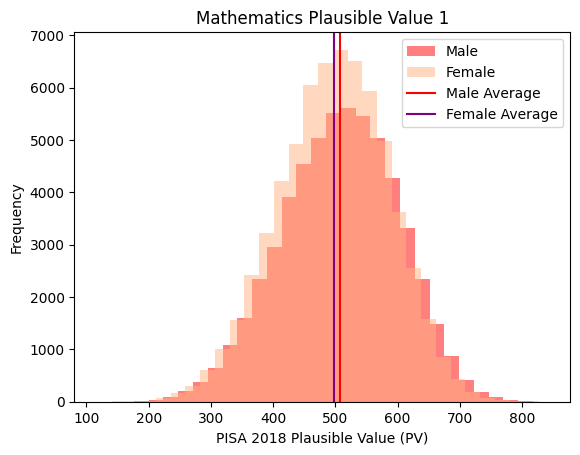

In [6]:
m = plt.hist(temp[temp["gender"] == 2]["PV1MATH"],bins=30,fc = (1,0,0,0.5),label = "Male")
f = plt.hist(temp[temp["gender"] == 1]["PV1MATH"],bins=30,fc = (1,0.7,0.5,0.5),label = "Female")
plt.xlabel("PISA 2018 Plausible Value (PV)")
plt.ylabel("Frequency")
plt.axvline(x = temp[temp["gender"] == 2]["PV1MATH"].mean(), color = 'red', label = 'Male Average')
plt.axvline(x = temp[temp["gender"] == 1]["PV1MATH"].mean(), color = 'purple', label = 'Female Average')
plt.title("Mathematics Plausible Value 1")
plt.legend()
plt.savefig(os.getcwd()+"/math_hist.png")
plt.show()

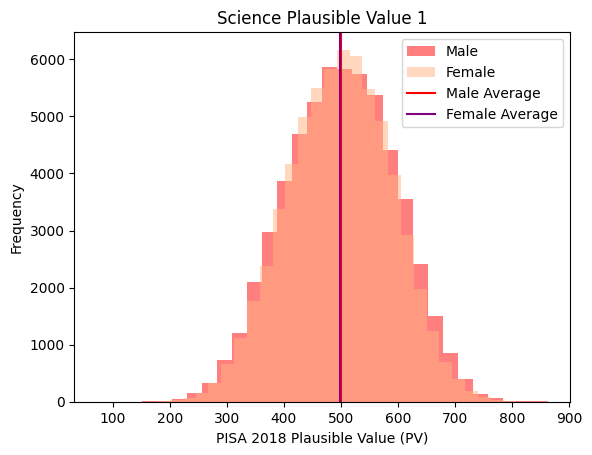

In [7]:
m = plt.hist(temp[temp["gender"] == 2]["PV1SCIE"],bins=30,fc = (1,0,0,0.5),label = "Male")
f = plt.hist(temp[temp["gender"] == 1]["PV1SCIE"],bins=30,fc = (1,0.7,0.5,0.5),label = "Female")
plt.xlabel("PISA 2018 Plausible Value (PV)")
plt.ylabel("Frequency")
plt.axvline(x = temp[temp["gender"] == 2]["PV1SCIE"].mean(), color = 'red', label = 'Male Average')
plt.axvline(x = temp[temp["gender"] == 1]["PV1SCIE"].mean(), color = 'purple', label = 'Female Average')
plt.title("Science Plausible Value 1")
plt.legend()
plt.savefig(os.getcwd()+"/science_hist.png")
plt.show()

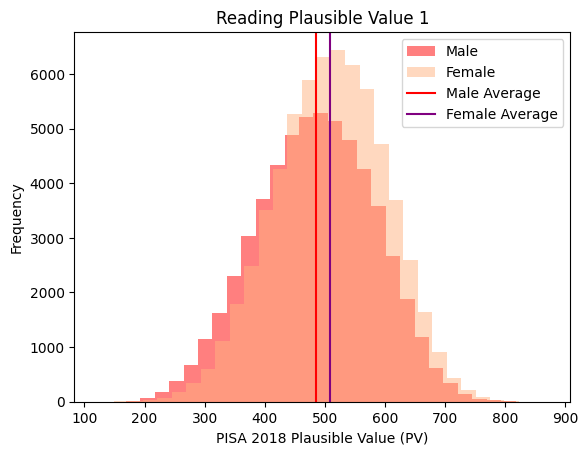

In [8]:
m = plt.hist(temp[temp["gender"] == 2]["PV1READ"],bins=30,fc = (1,0,0,0.5),label = "Male")
f = plt.hist(temp[temp["gender"] == 1]["PV1READ"],bins=30,fc = (1,0.7,0.5,0.5),label = "Female")
plt.xlabel("PISA 2018 Plausible Value (PV)")
plt.ylabel("Frequency")
plt.axvline(x = temp[temp["gender"] == 2]["PV1READ"].mean(), color = 'red', label = 'Male Average')
plt.axvline(x = temp[temp["gender"] == 1]["PV1READ"].mean(), color = 'purple', label = 'Female Average')
plt.title("Reading Plausible Value 1")
plt.legend()
plt.savefig(os.getcwd()+"/reading_hist.png")
plt.show()

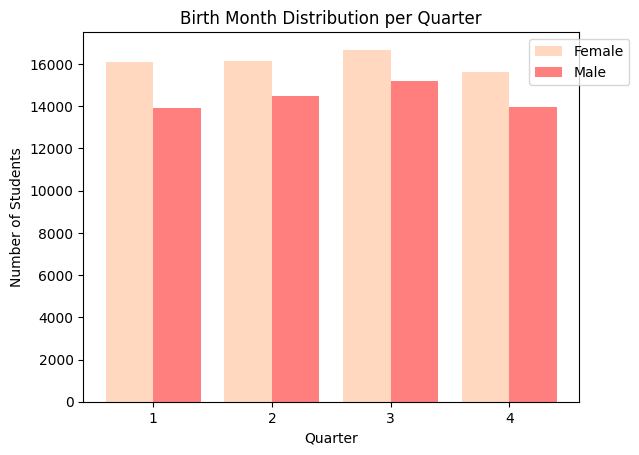

In [5]:
def quarter(x):
    if x <= 3.0:
        return 1
    elif x <= 6:
        return 2
    elif x <= 9:
        return 3
    else:
        return 4

temp['birth_quarter'] = temp['birth_month'].map(lambda x: quarter(x))

X = [1, 2, 3, 4] 
Ygirls = temp[temp["gender"] == 1].groupby("birth_quarter").count()[['PV1READ']].to_numpy().flatten()
Zboys = temp[temp["gender"] == 2].groupby("birth_quarter").count()[['PV1READ']].to_numpy().flatten()

X_axis = np.arange(len(X)) 

plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Female', fc = (1,0.7,0.5,0.5)) 
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Male', fc = (1,0,0,0.5)) 
  
plt.xticks(X_axis, X) 
plt.xlabel("Quarter") 
plt.ylabel("Number of Students") 
plt.title("Birth Month Distribution per Quarter") 
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper center')
plt.savefig(os.getcwd()+"/birth_quarter.png")
plt.show() 